In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from sotodlib import core
import sotodlib.io.load as io_load

import tools

#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

In [2]:
from sotodlib.core import FlagManager

import sotodlib.flags as flags
import sotodlib.sim_flags as sim_flags

import sotodlib.tod_ops.filters as filters

from sotodlib.tod_ops import fourier_filter, rfft, detrend_data

import tools
import importlib
#importlib.reload(tools)

In [21]:
# LF:0,95  MFF:95,190 MFS:190, 285  UHF:285,380
obs_num1, obs_num2 = 95,96
obs_num = obs_num2 - obs_num1

det_set_num1, det_set_num2 = 1, 2
det_set_num = det_set_num2 - det_set_num1

det_num1, det_num2 = 0, 10
det_num = det_num2 - det_num1

n_glitch = 2
heights = np.arange(1, 10, 1)

# signal/noise ranges
S_Ns = np.arange(10, 51, 1)

signal_name = 'bad_signal'

# Choose observation
nersc_todsims = '/global/project/projectdirs/sobs/todsims/pipe-s0001/v4/context.yaml'
# for simons 1
simons_todsims = '/mnt/so1/shared/todsims/pipe-s0002/v2/context/context.yaml'
#simons_todsims = './context.yaml'
context = core.Context(simons_todsims)
my_obs_list = context.obsdb.get()[obs_num1:obs_num2]
det_set_list = context.obsfiledb.get_detsets(my_obs['obs_id'])[det_set_num1:det_set_num2]

print('obs:', obs_num)
print('det_set:', det_set_num)
print('tod:', obs_num*det_set_num)
print('arrays:', obs_num * det_set_num*det_num)
for my_obs in my_obs_list:
    print(my_obs['obs_id'])
print(det_set_list)

obs: 1
det_set: 1
tod: 1
arrays: 10
CES-Atacama-LAT-Tier1DEC-035..-045_RA+040..+050-0-0_MFF
[]


In [5]:
## Test single tod

# Choose a single observation
my_obs = my_obs_list[0]

# Choose a single det_set
det_set_list = context.obsfiledb.get_detsets(my_obs['obs_id'])[det_set_num1:det_set_num2]
det_set = det_set_list[0]

# Choose dets from a det_set
dets = context.obsfiledb.get_dets(det_set)

# Get a single tod, my_obs include the information of a single observation and a single det_set
tod = context.get_obs(my_obs, dets=dets[det_num1:det_num2])

# Trim this tod
tsamp = np.median(np.diff(tod.timestamps))
n_cut = int(10//tsamp)
print('Trimming in time...')
tod.restrict('samps', (n_cut, tod.samps.count-n_cut))

Trimming in time...


AxisManager(signal[dets,samps], timestamps[samps], boresight*[samps], qboresight_azel[samps,4], qboresight_radec[samps,4], site*[samps], flags*[dets,samps], focal_plane*[dets], dets:LabelAxis(1), samps:OffsetAxis(50038))

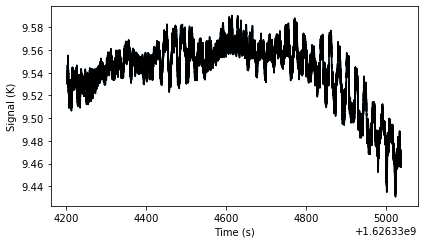

In [6]:
## Plot the tod
sig_mean = np.mean( tod.signal, axis = 0)
tod.wrap('sig_mean', sig_mean, [(0,tod.samps)])

fig = plt.figure(figsize=(6,3.5))
# hb: this loop is for the 10 detectors' measurements
for i in range(tod.dets.count):
    plt.plot(tod.timestamps, tod.signal[i])
if hasattr(tod, 'sig_mean'):
    plt.plot(tod.timestamps, tod.sig_mean, 'k-')
plt.xlabel('Time (s)')
plt.ylabel('Signal (K)')
fig.tight_layout()

In [7]:
## Add glitches
height = 5
n_glitch = 2
if 'badness' in tod:
    tod.move('badness', None)
    # add glitches
sim_flags.add_random_glitches(tod, params={'n_glitch':n_glitch, 'sig_n_glitch' : 0,'h_glitch':height}, \
                              signal='badness', overwrite='False')

if signal_name in tod:
    tod.move(signal_name, None)
# wrap the glitches to the tod
tod.wrap(signal_name, tod.signal+tod.badness, [(0, tod.dets), (1, tod.samps)])

AxisManager(signal[dets,samps], timestamps[samps], boresight*[samps], qboresight_azel[samps,4], qboresight_radec[samps,4], site*[samps], flags*[dets,samps], focal_plane*[dets], sig_mean[samps], badness[dets,samps], bad_signal[dets,samps], dets:LabelAxis(1), samps:OffsetAxis(50038))

In [8]:
tod

AxisManager(signal[dets,samps], timestamps[samps], boresight*[samps], qboresight_azel[samps,4], qboresight_radec[samps,4], site*[samps], flags*[dets,samps], focal_plane*[dets], sig_mean[samps], badness[dets,samps], bad_signal[dets,samps], dets:LabelAxis(1), samps:OffsetAxis(50038))

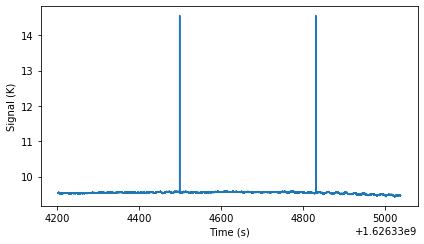

In [9]:
## Plot the tod
fig = plt.figure(figsize=(6,3.5))
# hb: this loop is for the 10 detectors' measurements
for i in range(tod.dets.count):
    plt.plot(tod.timestamps, tod.bad_signal[i])
plt.xlabel('Time (s)')
plt.ylabel('Signal (K)')
fig.tight_layout()

In [10]:
## Convolve time constant
# Firstly, tod is an AxisManager class, its repr is a odict
print(type(tod))
# Generate time const
tau = np.array([0.002] * tod.dets.count)
tod.wrap('timeconst', -tau, [(0,  tod.dets)])

<class 'sotodlib.core.axisman.AxisManager'>


AxisManager(signal[dets,samps], timestamps[samps], boresight*[samps], qboresight_azel[samps,4], qboresight_radec[samps,4], site*[samps], flags*[dets,samps], focal_plane*[dets], sig_mean[samps], badness[dets,samps], bad_signal[dets,samps], timeconst[dets], dets:LabelAxis(1), samps:OffsetAxis(50038))

In [11]:
## Convolve tod with timeconst
# How timeconst works?
filt_function = filters.tau_filter()
filt_tod = fourier_filter(tod, filt_function, signal_name='bad_signal')

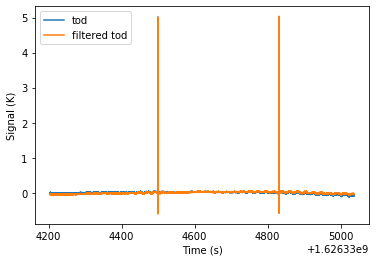

In [12]:
plt.plot(tod.timestamps, (tod.bad_signal - tod.bad_signal.mean(axis=1, keepdims=True))[0], label='tod')
plt.plot(tod.timestamps, filt_tod[0], label='filtered tod')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Signal (K)')
plt.savefig('./plots/timeconst.png')